# l-1 trend filtering 

В своей знаменитой статье [l-1 trend filtering](https://web.stanford.edu/~boyd/papers/l1_trend_filter.html) Стивен Бойд и его коллеги предложили подход к выявлению тренда в финансовых временных рядах с помощью выпуклой оптимизации. В частности, вместо построения стохастической модели временного ряда, они предложили отталкиваться от задачи - построить кусочно-линейную линию тренда, наилучшим образом аппроксимирующую данный временной ряд.

Это привело к задачи оптимизации следующего вида:

**TrendFilter problem**
$$
\min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1
$$
где $y \in R^T$ - временной ряд фактических цен акции (с момента времени $t = 1$ до момента времени $T$), матрица $D \in R^{(T-2) \times T}$ является трехдиагональной: $[Dx]_i = x_i - 2 \cdot x_{i+1} + x_{i+2} \quad$ ($1\leq i \leq T-2$).

Первый член в целевой функции отвечает за близость решения к фактическим данным, а второй форсирует решение  быть кусочно-линейной функцией с минимальным числом "изломов". 

Попробуем решить данную задачу методом проксимального градиентного спуска, методом сглаживания Нестерова и ADMM, а затем сравним их

# 1. Тестовые данные


Это данные по торгам акций аэрофлота за период 06.04-04.05 с интервалом 1 минута

In [8]:
import pandas as pd
import numpy as np
import scipy.sparse
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
df = pd.read_csv("AFLT_220406_220504.csv", sep=",")
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,AFLT,1,20220406,100100,37.50,37.60,36.14,36.32,247420
1,AFLT,1,20220406,100200,36.58,36.90,36.20,36.32,126500
2,AFLT,1,20220406,100300,36.34,36.62,36.08,36.40,149400
3,AFLT,1,20220406,100400,36.40,36.48,36.12,36.30,156810
4,AFLT,1,20220406,100500,36.30,36.44,36.28,36.32,83740
...,...,...,...,...,...,...,...,...,...
9612,AFLT,1,20220504,124300,31.60,31.68,31.58,31.64,10830
9613,AFLT,1,20220504,124400,31.64,31.64,31.60,31.64,8480
9614,AFLT,1,20220504,124500,31.62,31.66,31.62,31.66,940
9615,AFLT,1,20220504,124600,31.64,31.68,31.62,31.68,3810


# 2. Двойственность

$$  \min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1 $$

$$\Big\Updownarrow$$

$$ \min_{x, z} \frac{1}{2}\|y - x\|_2^2 + \lambda \|z\|_1 $$

$$s.t. Dx = z$$


$$L(x,z,\mu) = \frac{1}{2}||y-x||_2^2 + \lambda\|z\|_1 + \mu^T(Dx-z) = \frac{1}{2}||y-x||_2^2 + \mu^TDx + \lambda1^Tz - \mu^Tz) $$

$$g(\mu) = \displaystyle\inf_{x,z} (L(x,z,\mu)) = \displaystyle\inf_{x} L(x,\mu) + \displaystyle\inf_{z} L(z,\mu) $$

$$\displaystyle\inf_{z} L(z,\mu) = \lambda1^Tz - \mu^Tz = (\lambda1^T - \mu^T)z $$

$$\displaystyle\inf_{z} (\lambda1^T - \mu^T)z = 0 \quad \text{если} -\lambda1_i \leq \mu_i \leq \lambda1_i , \quad \text{иначе} -\infty$$


FOOC:
$$(\frac{1}{2}||y-x||_2^2 + \mu^TDx)'_x = -y + x + D^T\mu$$

$$x^* = y - D^T\mu$$

Тогда 

$$g(\mu) = \frac{1}{2}||y-(y - D^T\mu)||_2^2 + \mu^TD(y - D^T\mu) = \frac{1}{2}||D^T\mu)||_2^2 + \mu^TDy - \mu^TDD^T\mu = \frac{1}{2}(\mu^TD)(D^T\mu) + \mu^TDy - \mu^TDD^T\mu = -\frac{1}{2}\mu^TDD^T\mu + \mu^TDy$$


$$(D) \displaystyle\max_{\mu} -\frac{1}{2}\mu^TDD^T\mu + \mu^TDy = \displaystyle\min_{\mu} \frac{1}{2}\mu^TDD^T\mu - \mu^TDy$$

$$s.t. -\lambda1_i \leq \mu_i \leq \lambda1_i$$

$$x^{*} = y − D^T v^{*}$$

# Proximal Gradient Descent


Будем оптимизировать двойственную задачу, так как в исходной прокс оператор не считается

$$f(\mu) = \frac{1}{2}\mu^TDD^T\mu - \mu^TDy + \mathbb{1}(-\lambda1_i \leq \mu_i \leq \lambda1_i)$$


$$h(\mu) = \frac{1}{2}\mu^TDD^T\mu - \mu^TDy$$
$$h'(\mu) = DD^T\mu - Dy$$

$$g(\mu_i) = \mathbb{1}(-\lambda1_i \leq \mu_i \leq \lambda1_i) $$

$$prox(v)_{g, \alpha} = argmin_{x_i} ((v_i - x_i)^2 + \mathbb{1}(-\lambda1_i \leq x_i \leq \lambda1_i)) =  argmin_{-\lambda1_i \leq x_i \leq \lambda1_i} (v_i - x_i)^2 = \pi_{-\lambda1_i \leq x_i \leq \lambda1_i}(v_i)$$


$$\pi_{-\lambda1_i \leq x_i \leq \lambda1_i}(v_i)$$

$$ \pi_{-\lambda1_i \leq x_i \leq \lambda1_i}(v_i) =
  \begin{cases}
    v_i       & \quad \text{if } v_i \in [-\lambda, \lambda]\\
    \lambda  & \quad \text{if } v_i > \lambda \\
    -\lambda & \quad \text{if } v_i < -\lambda
  \end{cases}
$$


$$\pi_{-\lambda1_i \leq x_i \leq \lambda1_i}(v_i) = \max(0, |v_i| - \lambda)*-sign(v_i) + v_i$$

$$\mu^{t+1} = prox(\mu^t - \alpha \nabla h(\mu^t))$$

$$x^{*} = y − D^T \mu^{*}$$

In [3]:
def prox_grad_method(mu0, alpha, num_iter, h_grad, g_prox):
    conv = [mu0.copy()]
    mu = mu0.copy()
    for i in tqdm(range(num_iter)):
        grad = h_grad(mu)
        mu = g_prox(mu - alpha * grad)
        x = y - D.T @ mu
        conv.append(x.copy())
    return x, conv


h_grad = lambda mu: DDt @ mu - Dy
g_prox = lambda mu: (
    np.maximum(np.zeros_like(mu), np.abs(mu) - lam) * -np.sign(mu) + mu
)
g = (
    lambda mu: 0.5 * mu.T @ DDt @ mu
    - mu.T @ Dy
    + np.max(np.zeros_like(mu), np.abs(mu) - alpha) * big_const
)

f = lambda x: 0.5 * np.linalg.norm((x - y)) ** 2 + lam * np.linalg.norm(D @ x, 1)

In [4]:
y = df["<CLOSE>"].values
n = y.shape[0]
ones_row = np.ones((1, n))
D = scipy.sparse.spdiags(
    np.vstack((ones_row, -2 * ones_row, ones_row)), range(3), n - 2, n
)
D = D.toarray()
DDt = D @ D.T
Dy = D @ y
# D_inv = D

big_const = 10**9
mu0 = np.random.randn(n - 2)

In [5]:
lam = 1
max_iter = 1000
alpha = 1e-2

In [6]:
x_ista, conv_ista = prox_grad_method(mu0, alpha, max_iter, h_grad, g_prox)

100%|██████████| 1000/1000 [00:39<00:00, 25.21it/s]


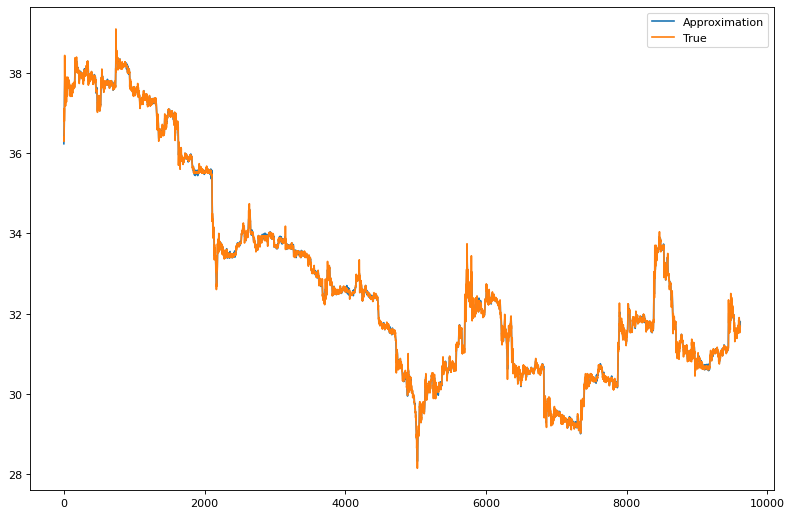

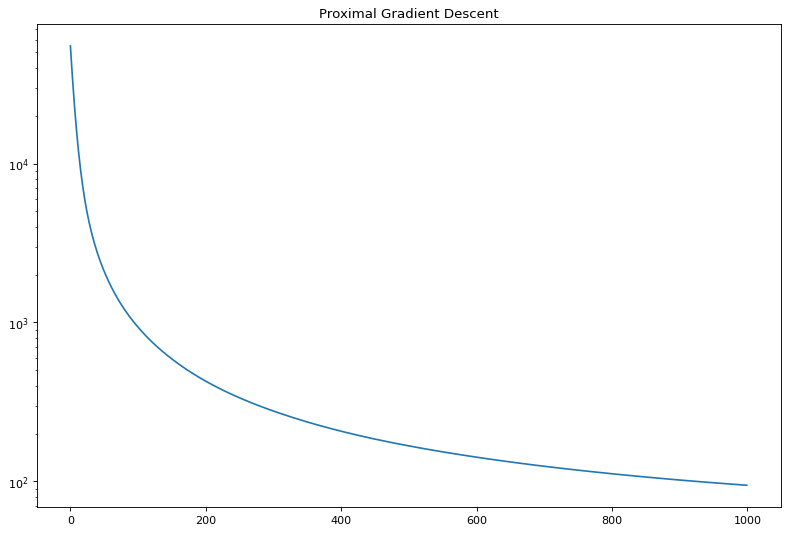

In [7]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(conv_ista[-1], label="Approximation")
plt.plot(y, label="True")
plt.legend()
plt.show()

plt.figure(figsize=(12, 8), dpi=80)
plt.semilogy([f(x) for x in conv_ista[1:]])
plt.title("Proximal Gradient Descent")
plt.show()

# Nesterov Smoothing

Здесь мы представим нашу функцию как сумму двух, одну из которых сгладим сильно выпуклой

Итак наша изначальная функция 

$$ \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1$$

Запишем ее компоненты 

$$g(x) = \frac{1}{2}\|y - x\|_2^2$$

$$h(x) =\lambda \|Dx\|_1 $$

Чтобы перейти к сглаживанию необходимо представить первую норму с помощью максимума

$$\lambda \|Dx\|_1 = \displaystyle\max_{u \in Q_2} \{\lambda u^TDx\}$$, где $$Q_2 = [-1,1]$$

теперь добавим сильно выпуклую функцию для выпуклости. Возьмем в качестве нее вторую норму в квадрате, с коэффициентом сильной выпуклости = 2

$$h_\mu(x) = \displaystyle\max_{u \in Q_2} \{\lambda u^TDx - \cfrac{\mu}{2}||u||_2^2\} = \sum\limits_{i=1}^{T-2} \displaystyle\max_{u_i \in Q_2} \{\lambda u_i^TDx_i - \cfrac{\mu}{2}||u_i||_2^2\}$$

Можно рассмотреть покомпонентно и тогда функцию можно свести к форме напоминающей Лосс Хьюбера[1]

$$  =
  \begin{cases}
    \frac{a^2}{2\delta}       & \quad \text{если} |a| \leq \delta \\
    |a| - \frac{\delta}{2} & \quad \text{иначе} 
  \end{cases}
$$,
где $$ a = \lambda Dx_i, \delta = \mu$$


[1] Huber, Peter J. (1964). "Robust Estimation of a Location Parameter". Annals of Statistics. 53 (1): 73–101. doi:10.1214/aoms/1177703732. JSTOR 2238020.


In [81]:
def h_mu(x):
    a = lam * D @ x
    a[(a <= mu)] = (a[(a <= mu)] ** 2) / (2 * mu)
    a[(a > mu)] = np.abs(a[(a > mu)]) - (mu / 2)
    return a.sum()

In [82]:
def h_mu_grad(x):
    a = lam * D @ x
    a[np.abs(a) <= mu] = a[np.abs(a) <= mu] / mu
    a[a > mu] = 1
    a[a < -mu] = -1
    return lam * D.T @ a

In [94]:
def NesterovSmoothedFGM(x0, f_grad, num_iter):
    x = x0.copy()
    z = x.copy()
    x_prev = x0.copy()

    conv = [x]

    for i in tqdm(range(num_iter)):
        x = z - alpha * f_grad(z)
        z = x + ((i + 1) * (x - x_prev)) / (i + 4)
        x_prev = x.copy()

        conv.append(x.copy())
    return x, conv


f = lambda x: 0.5 * (y - x) @ (y - x) + h_mu(x)

f_grad = lambda x: x - y + h_mu_grad(x)

In [112]:
lam = 1
max_iter = 1000
alpha = 1e-2
mu = 10

In [113]:
x0 = np.random.randn(n)

In [114]:
res, fgm = NesterovSmoothedFGM(x0, f_grad, max_iter)

100%|██████████| 1000/1000 [05:58<00:00,  2.79it/s]


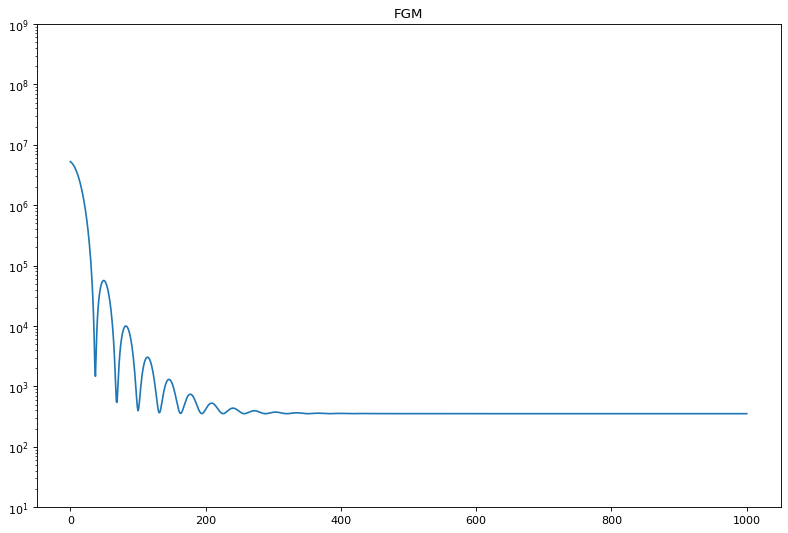

In [115]:
plt.figure(figsize=(12, 8), dpi=80)
plt.semilogy([f(x) for x in fgm])
plt.yticks([10**i for i in range(1, 10)])
plt.title("FGM")
plt.show()

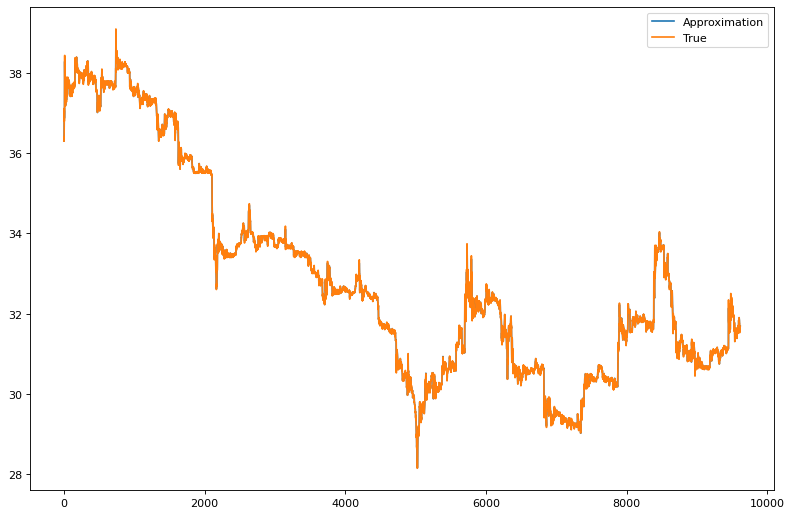

In [116]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(fgm[-1], label="Approximation")
plt.plot(y, label="True")
plt.legend()
plt.show()

# ADMM

Будем также рассматривать ADMM для двойственной задачи, потому что прокс не берется для прямой :(

$$f(\mu) = \frac{1}{2}\mu^TDD^T\mu - \mu^TDy + \mathbb{1}(-\lambda1_i \leq \mu_i \leq \lambda1_i) \rightarrow \displaystyle\min_{\mu} $$

Проведем замену $$\mu = \xi$$ и тогда наша функция может быть выражена через 2 составляющие

$$g(\xi) = \mathbb{1}(-\lambda1_i \leq \xi_i \leq \lambda1_i)$$


$$h(\mu) = \frac{1}{2}\mu^TDD^T\mu - \mu^TDy$$

Для данных функций распишем обобщенный Лагранжиан

$$L(\mu, \xi, \eta) = h(\mu) + g(\xi) + \frac{r}{2}||\mu-\xi + \frac{\eta}{r}||^2_2 - \frac{||\eta||_2^2}{2r}$$

Теперь можем посчитать правила обновления переменных 

$$\mu^{t+1} = argmin_{\mu} L(\mu, \xi^t, \eta^t) = argmin_{\mu} (\frac{1}{2}\mu^TDD^T\mu - \mu^TDy + \frac{r}{2}||\mu-\xi + \frac{\eta}{r}||^2_2) = DD^T\mu - Dy + r(\mu - \xi + \frac{\eta}{r})$$

$$DD^T\mu - Dy + r(\mu - \xi + \frac{\eta}{r}) = 0 $$
$$DD^T\mu + r\mu = Dy + r\xi - \eta $$
$$\mu^{t+1}= (DD^T + r*I)^{-1}(Dy + r\xi^t - \eta^t) $$


$$\xi^{t+1} = argmin_{\xi} L(\mu^{t+1}, \xi, \eta^t) = $$
Получается относительно тоже самое, что в пункте с прокс градом
$$= \pi_{-\lambda1_i \leq x_i \leq \lambda1_i}(\mu^{t+1} + \frac{eta^t}{r}) $$


$$\eta^{t+1} = \eta^t + r(\mu^{t+1} - \xi^{t+1})$$


In [31]:
def admm(mu0, xi0, eta0, r, max_iter):
    mu = mu0.copy()
    xi = xi0.copy()
    x = y - D.T @ mu
    eta = eta0.copy()
    conv = [x]

    for i in tqdm(range(max_iter)):
        mu = update_mu(xi, eta)

        xi = proj(mu + eta / r)
        eta = update_eta(eta, mu, xi)
        x = y - D.T @ mu
        conv.append(x.copy())
    return x, conv


proj = lambda x: np.minimum(np.abs(x), lam) * np.sign(x)


def update_mu(xi, eta):
    return inv @ (Dy + r * xi - eta)


def update_eta(eta, mu, xi):
    return eta + r * (mu - xi)

In [28]:
mu0 = np.random.randn(n - 2)
xi0 = np.random.randn(n - 2)
eta0 = np.random.randn(n - 2)
inv = np.linalg.inv((D @ D.T + r * np.eye(n - 2)))
Dy = D @ y

In [ ]:
r = 10
max_iter = 1000

In [32]:
res, admm_res = admm(mu0, xi0, eta0, r, max_iter)

100%|██████████| 1000/1000 [00:36<00:00, 27.34it/s]


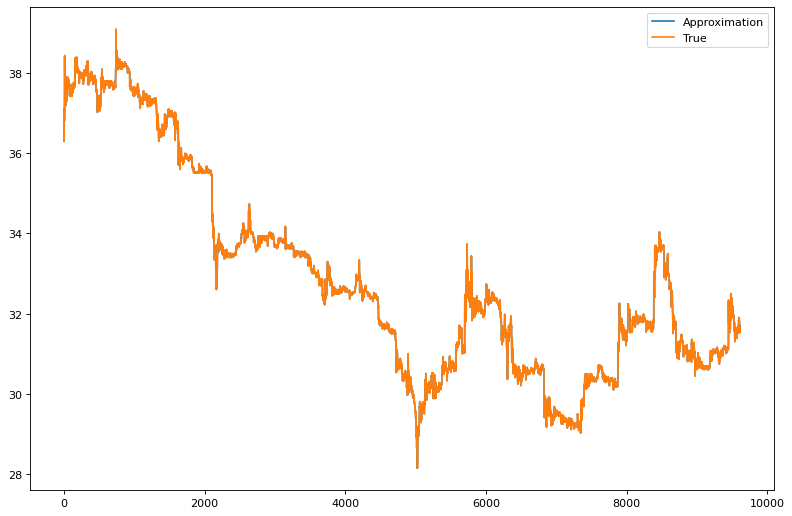

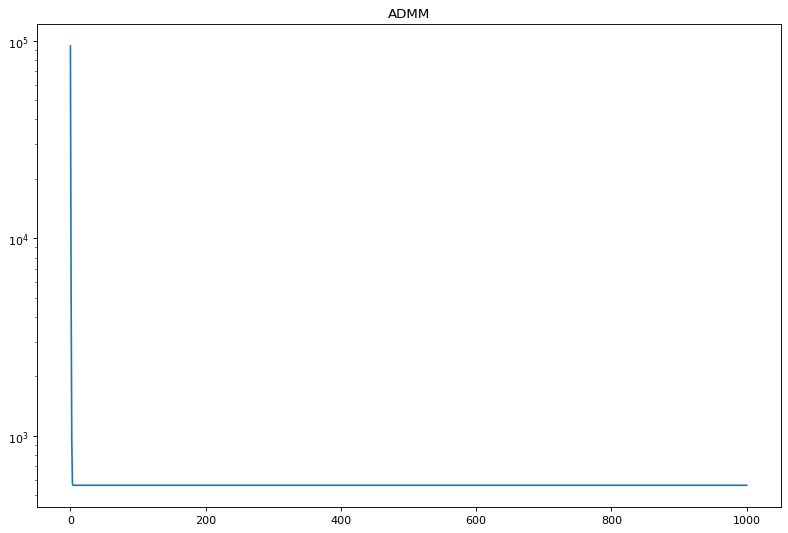

In [118]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(admm_res[-1], label="Approximation")
plt.plot(y, label="True")
plt.legend()
plt.show()

plt.figure(figsize=(12, 8), dpi=80)
plt.semilogy([f(x) for x in admm_res])
plt.title("ADMM")
plt.show()

# Результаты

In [109]:
f = lambda x: 0.5 * np.linalg.norm((x - y)) ** 2 + lam * np.linalg.norm(D @ x, 1)

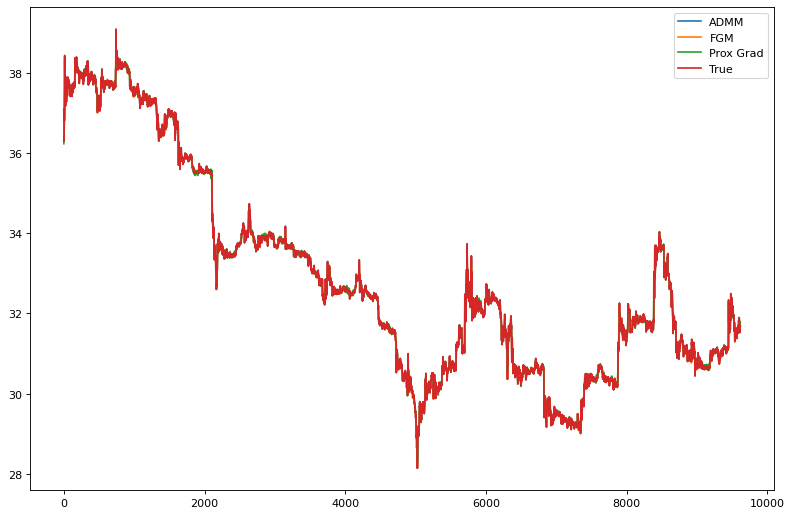

In [108]:
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(admm_res[-1], label="ADMM")
plt.plot(fgm[-1], label="FGM")
plt.plot(conv_ista[-1], label="Prox Grad")
plt.plot(y, label="True")
plt.legend()
plt.show()

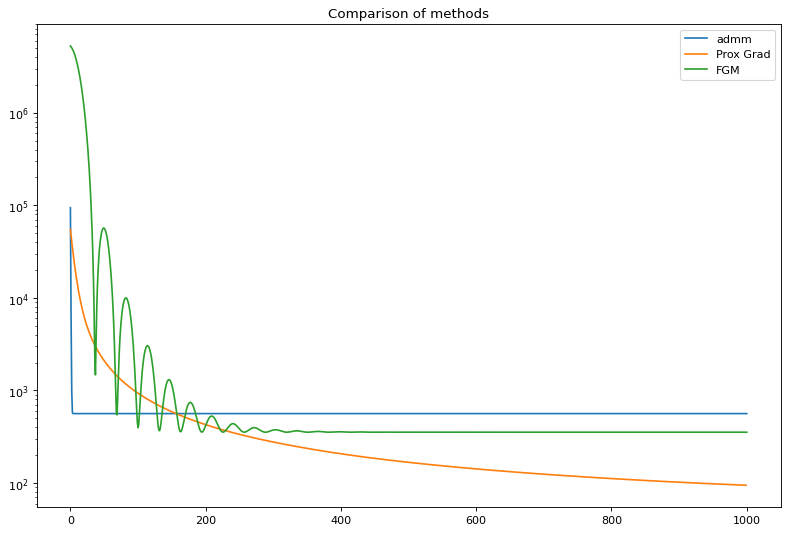

In [117]:
plt.figure(figsize=(12, 8), dpi=80)
plt.semilogy([f(x) for x in admm_res], label="admm")
plt.semilogy([f(x) for x in conv_ista[1:]], label="Prox Grad")
plt.semilogy([f(x) for x in fgm], label="FGM")
plt.title("Comparison of methods")
plt.legend()
plt.show()